In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
import multirecording_spikeanalysis as spike
from pathlib import Path

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')
df2 = df.dropna()
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)]

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })


# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)


# Construct the path in a platform-independent way
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230618_100636_standard_comp_to_omission_D2_subj_1-4_t4b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230620_114347_standard_comp_to_omission_D4_subj_1-2_t3b3L_box_1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230621_111240_standard_comp_to_omission_D5_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230617_115521_standard_comp_to_omission_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230619_115321_standard_comp_to_omission_D3_subj_1-4_t3b3L_box2_merged.r

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

In [3]:
pickle.dump(ephys_data, open("ephys_data.pkl", "wb"))

In [4]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data)

All set to analyze


/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too

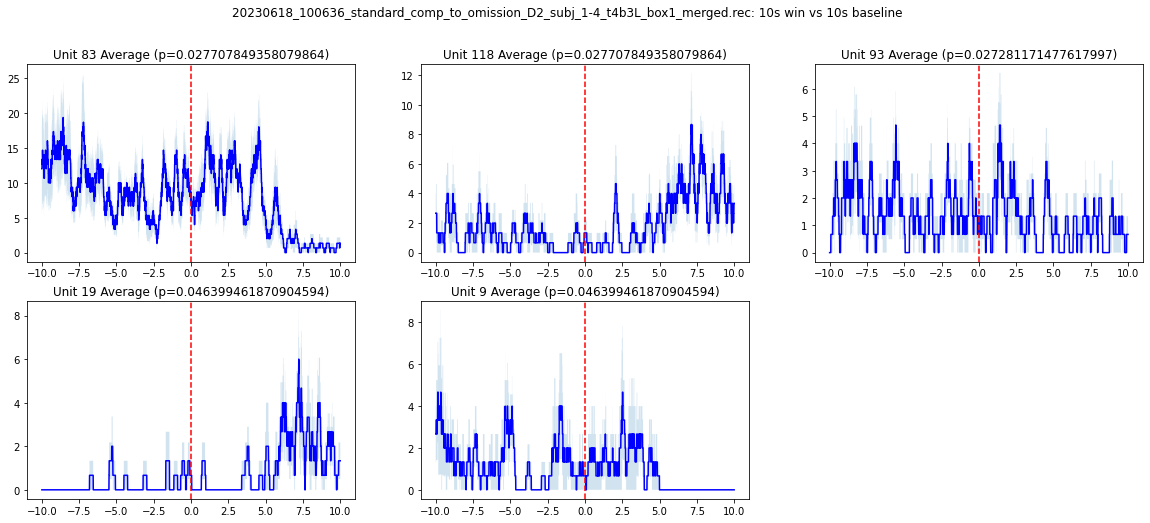

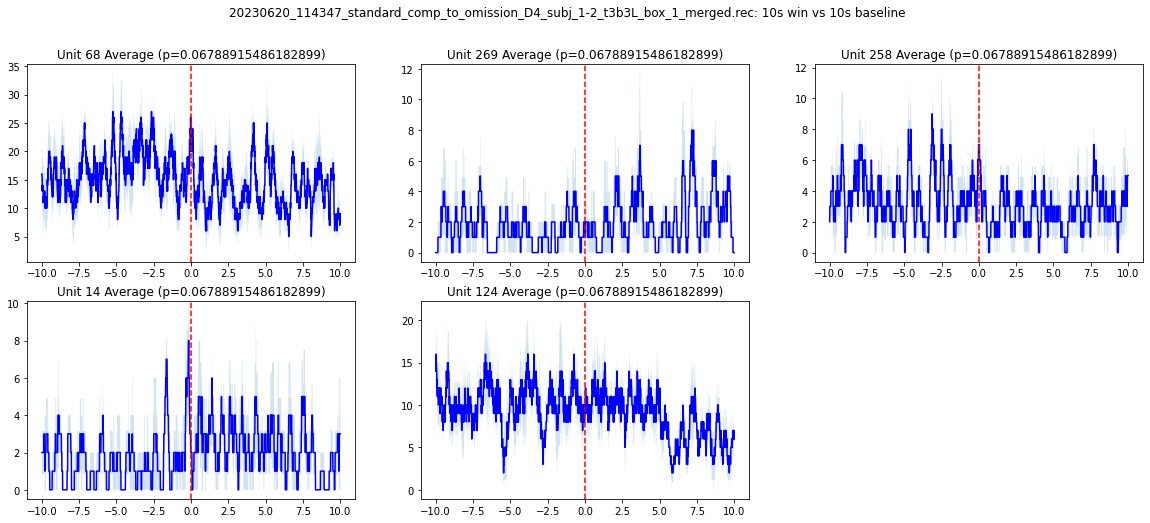

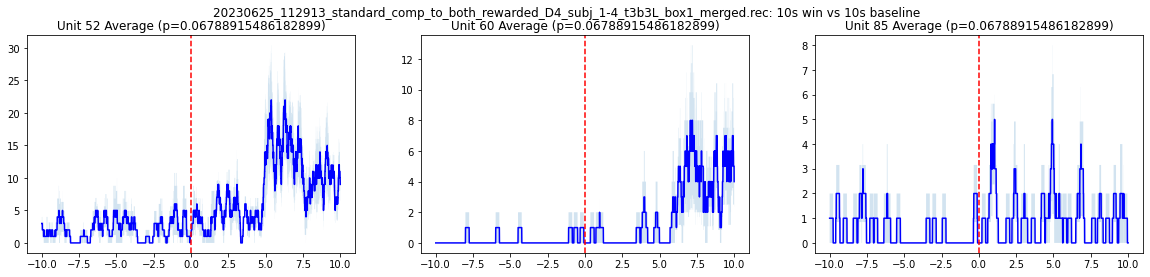

<Figure size 1440x0 with 0 Axes>

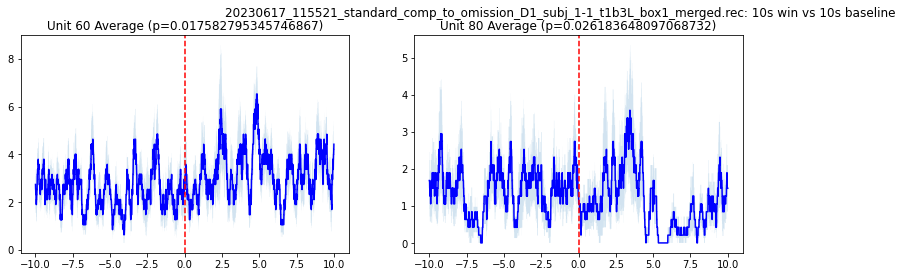

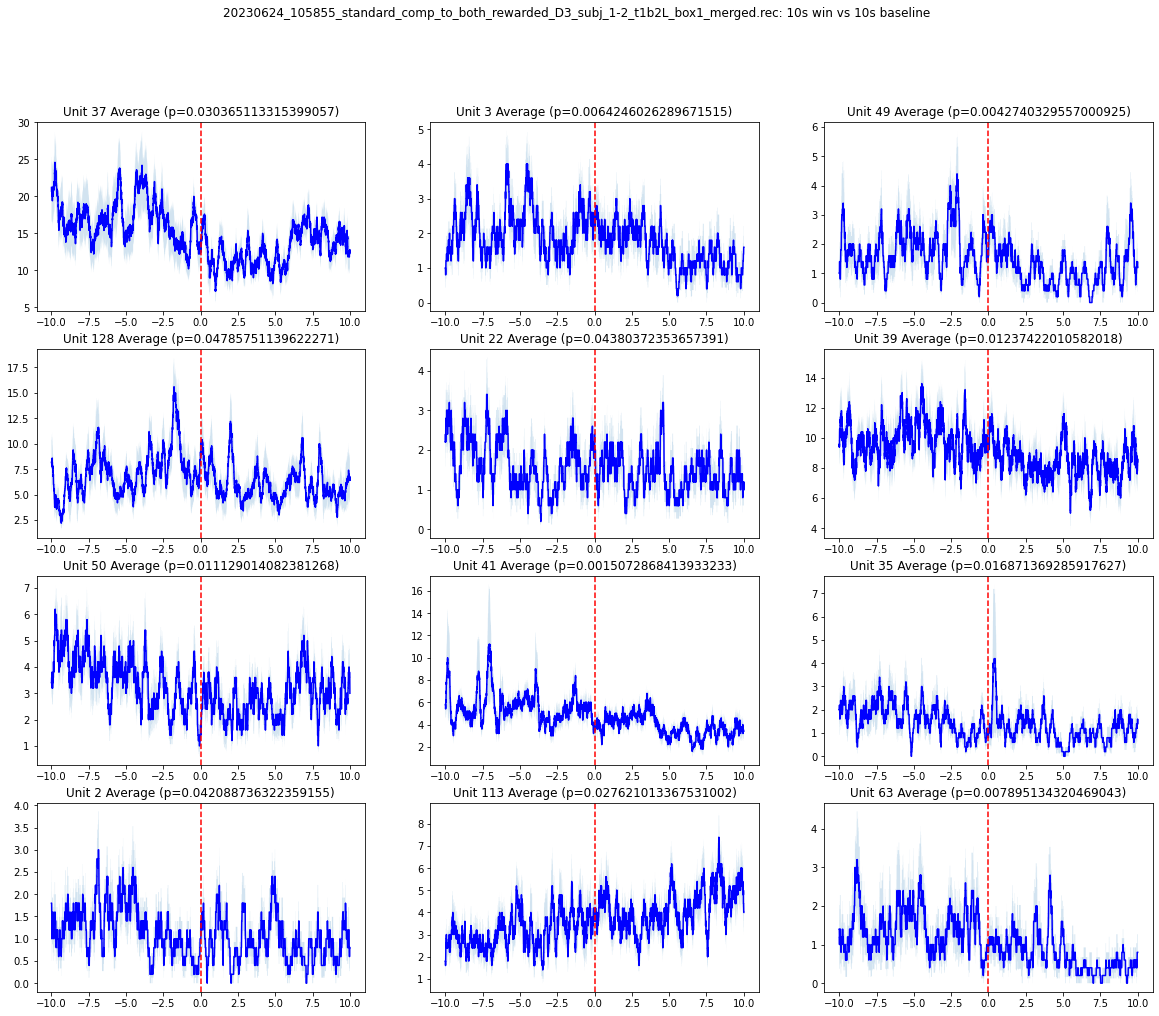

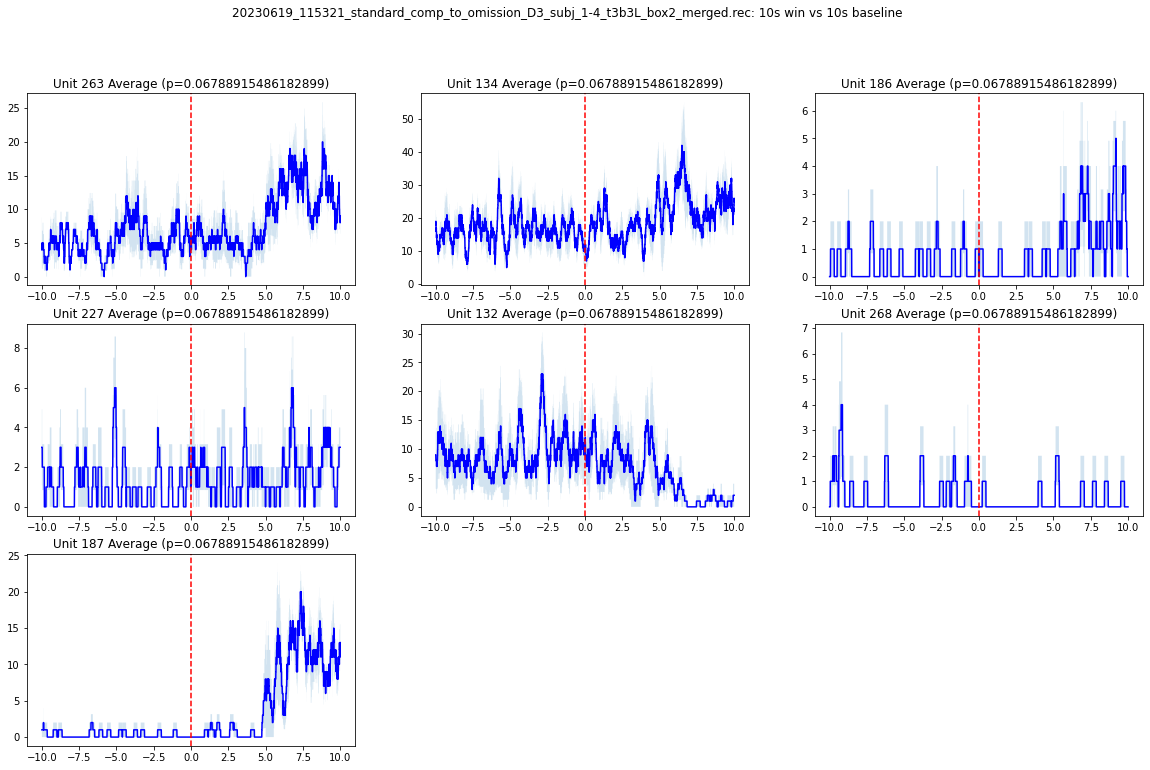

<Figure size 1440x0 with 0 Axes>

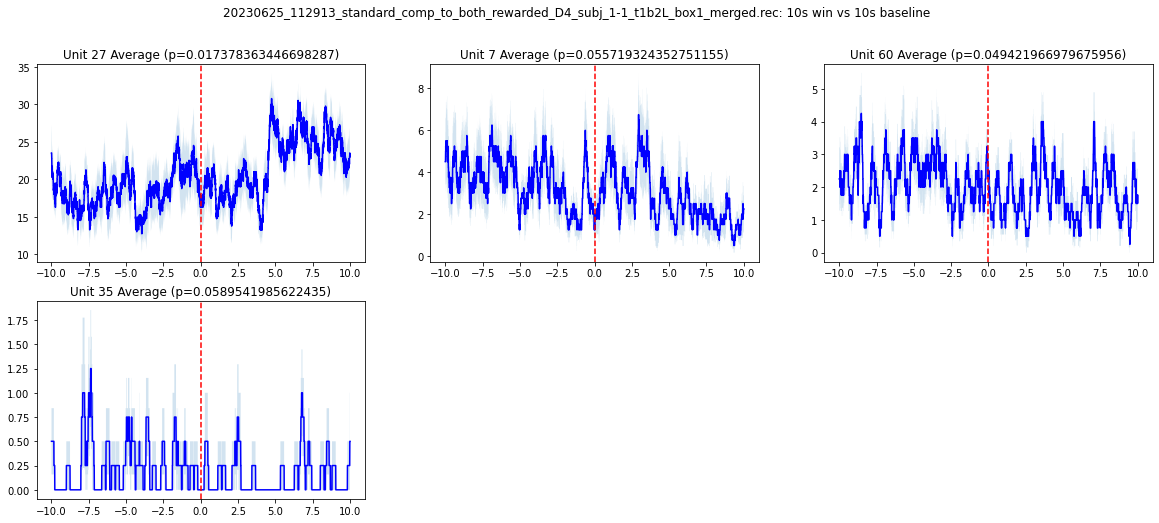

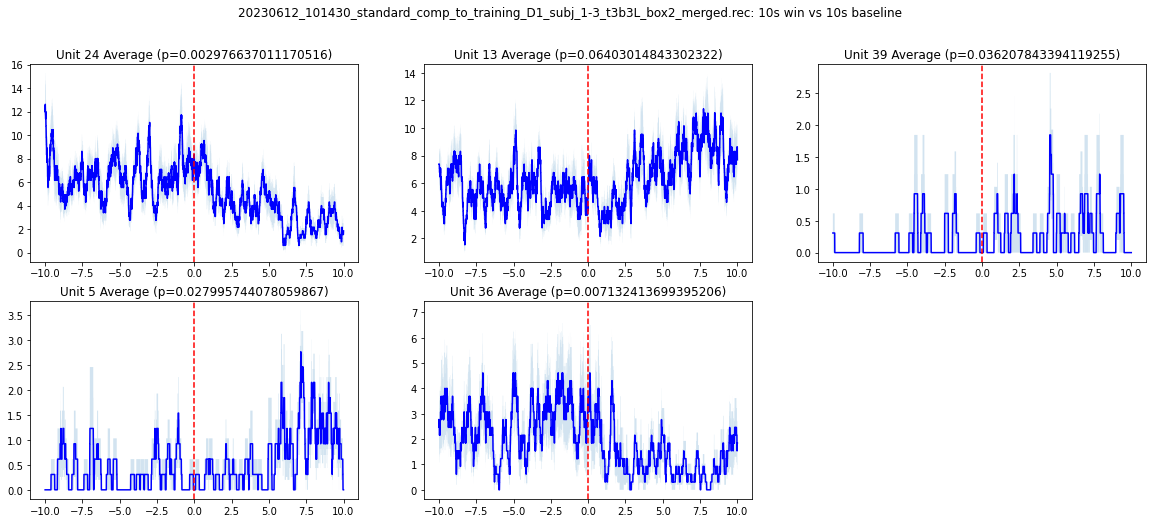

<Figure size 1440x0 with 0 Axes>

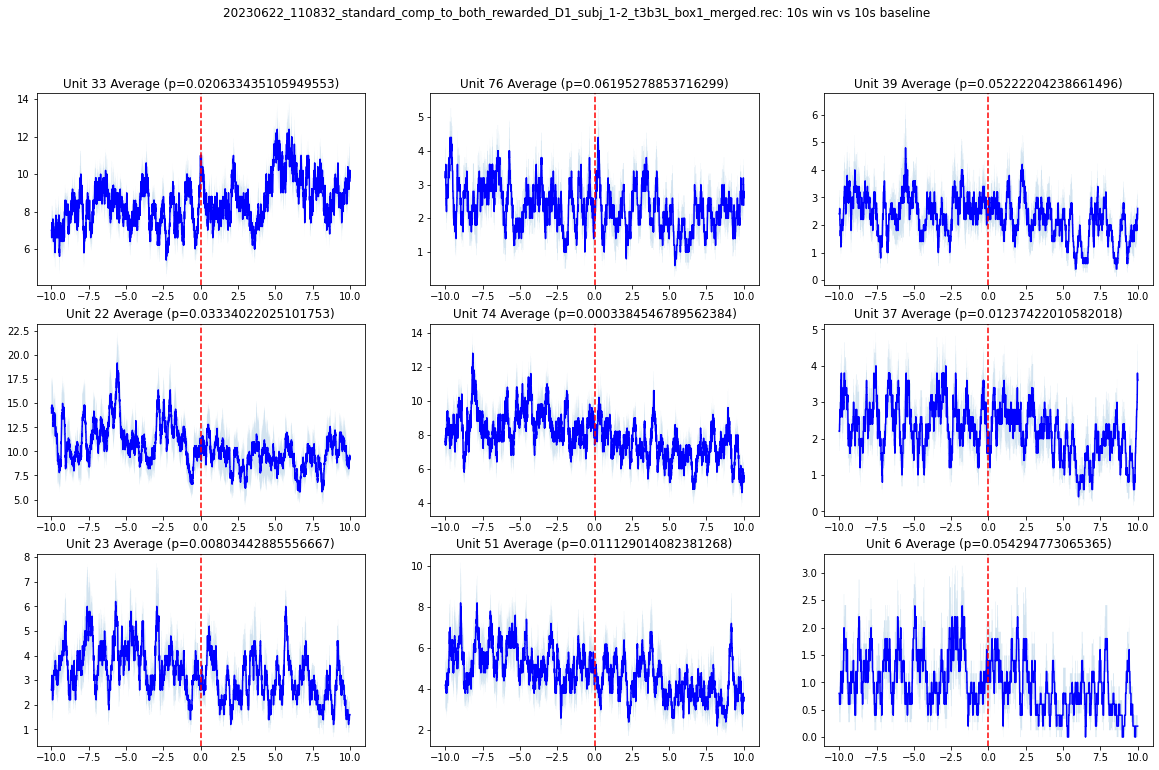

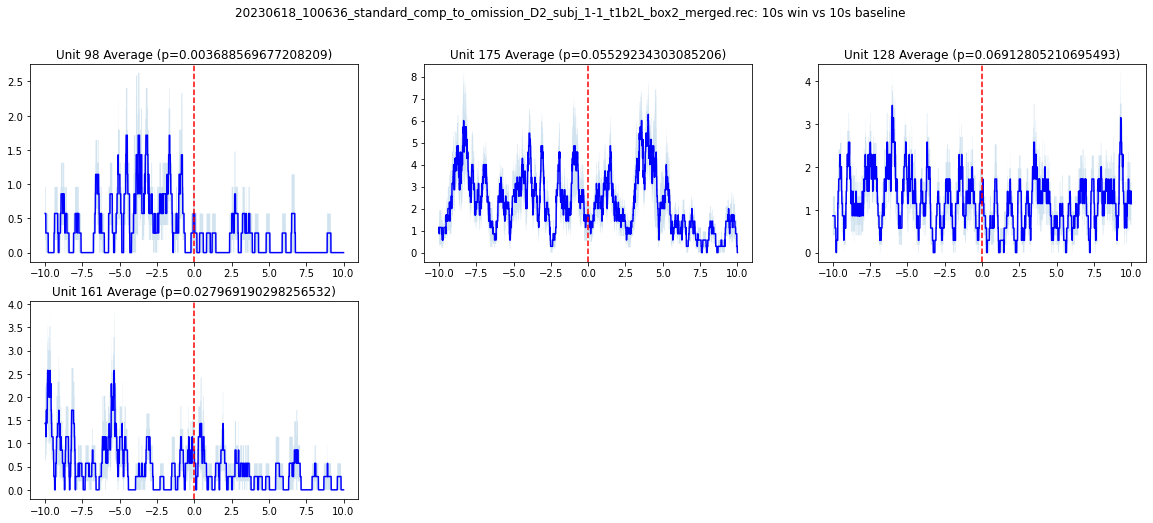

<Figure size 1440x0 with 0 Axes>

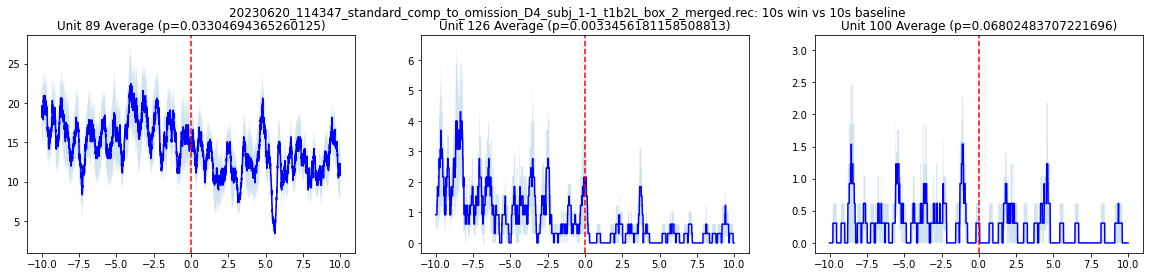

In [13]:
ephys_win = spike_analysis.wilcox_baseline_v_event_collection('win', 10, 10)

/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too

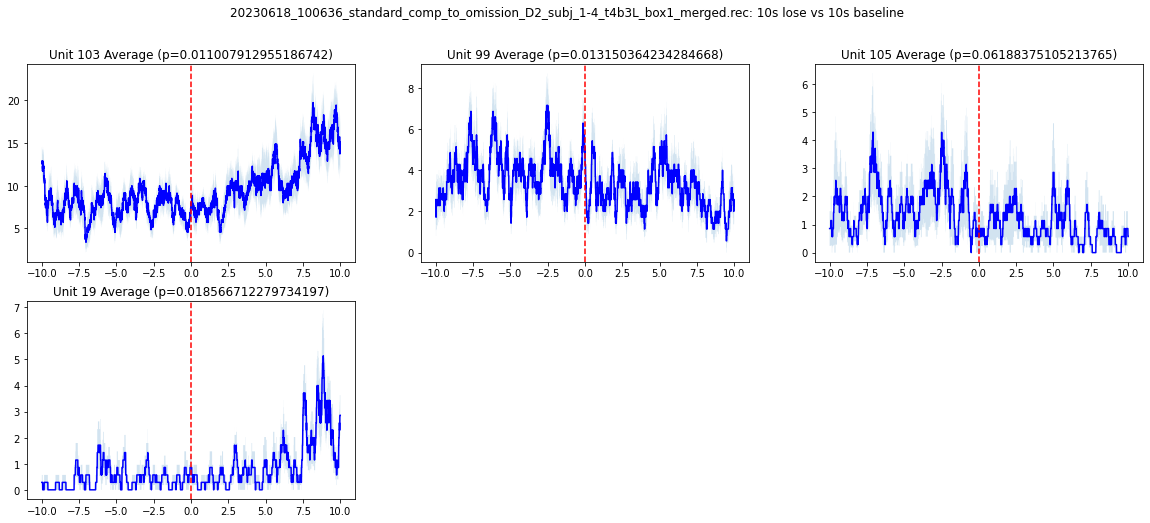

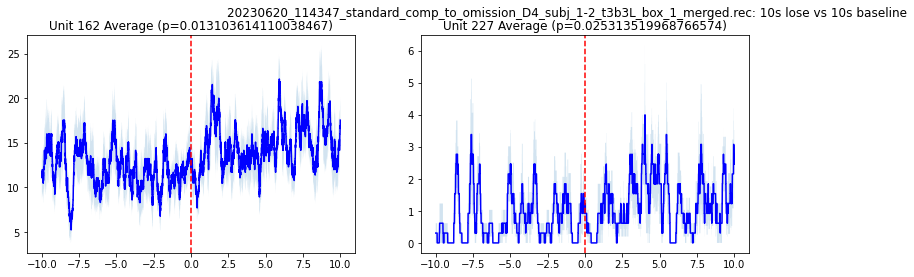

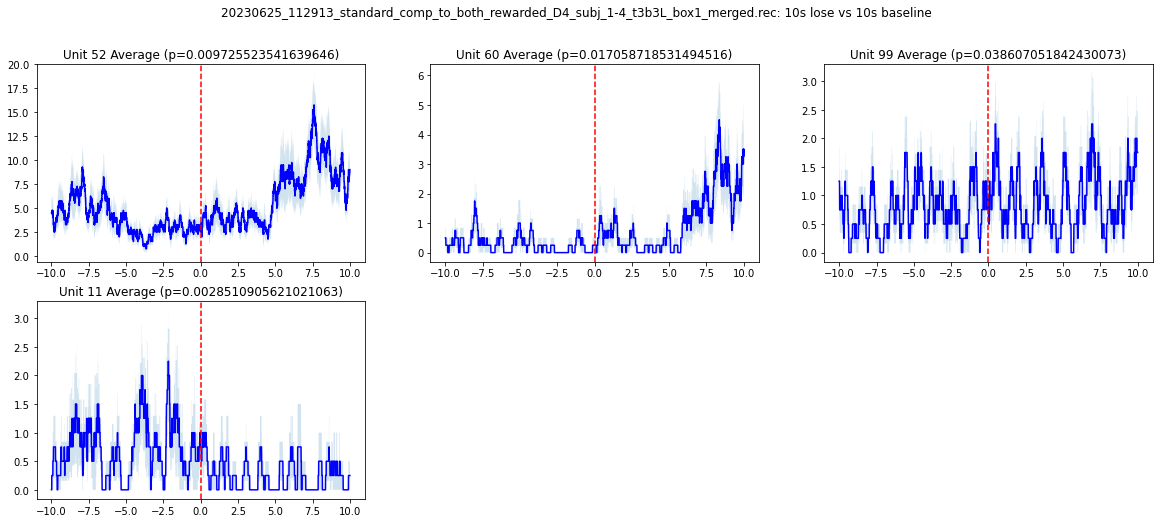

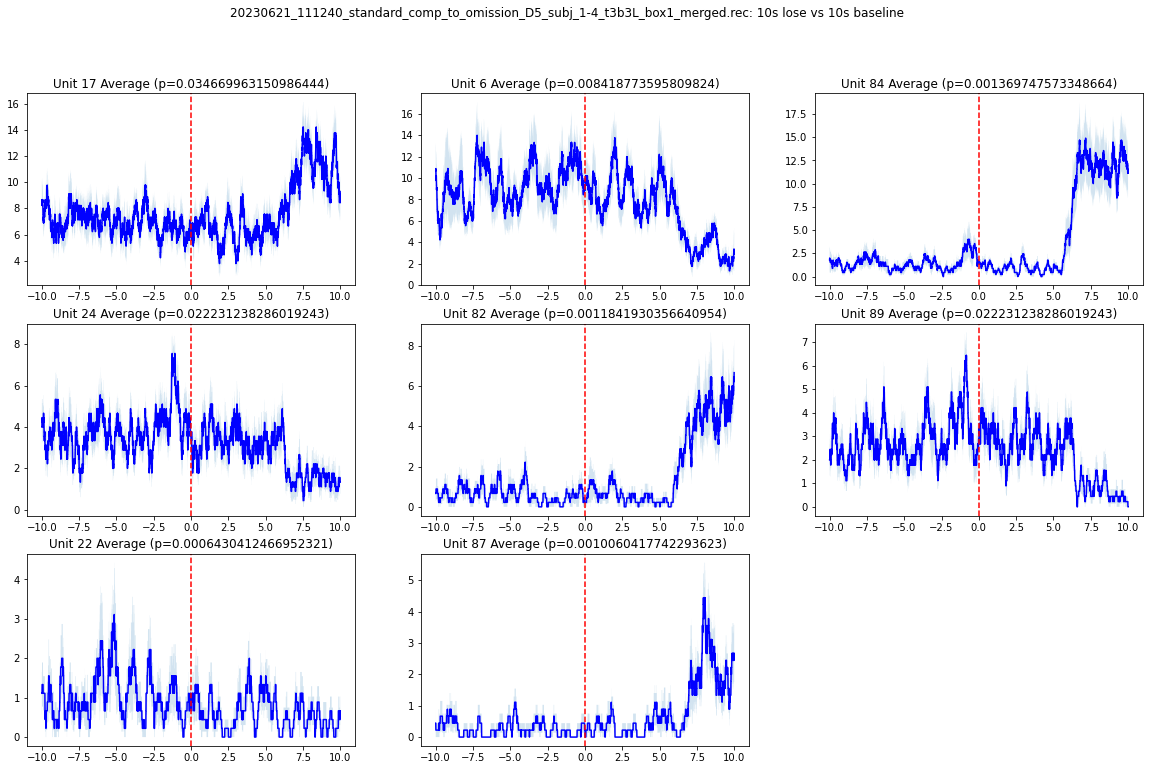

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

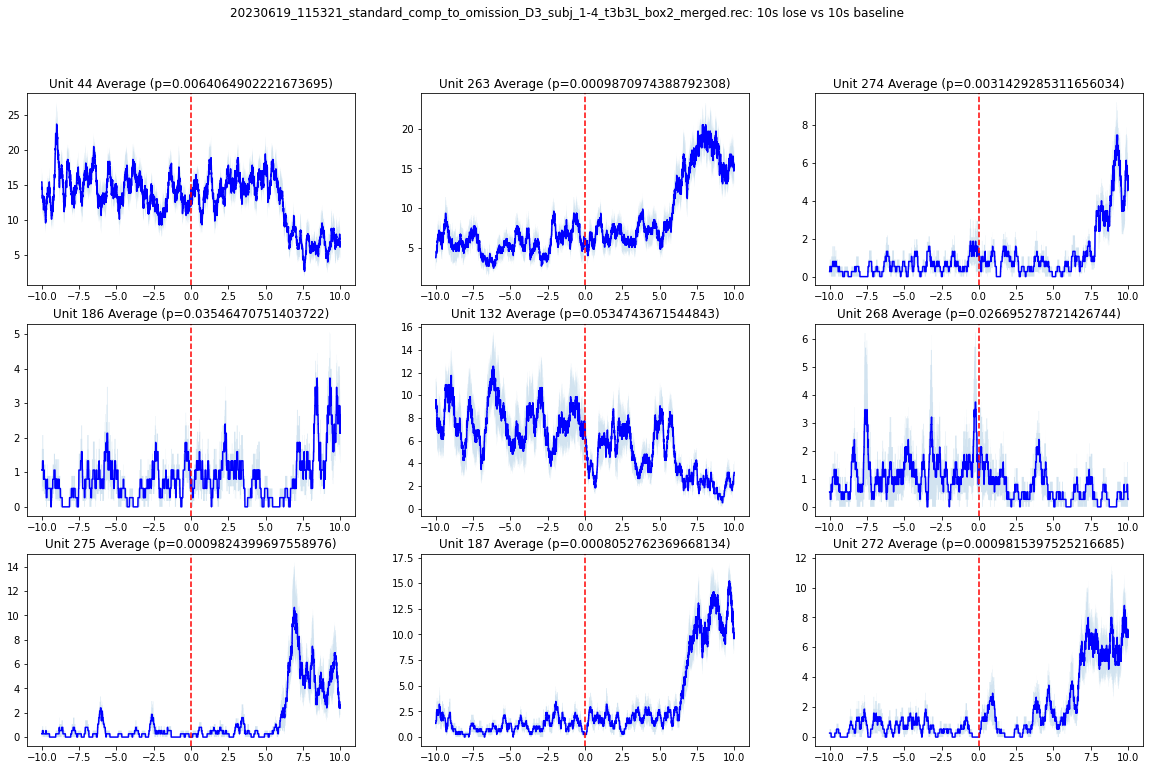

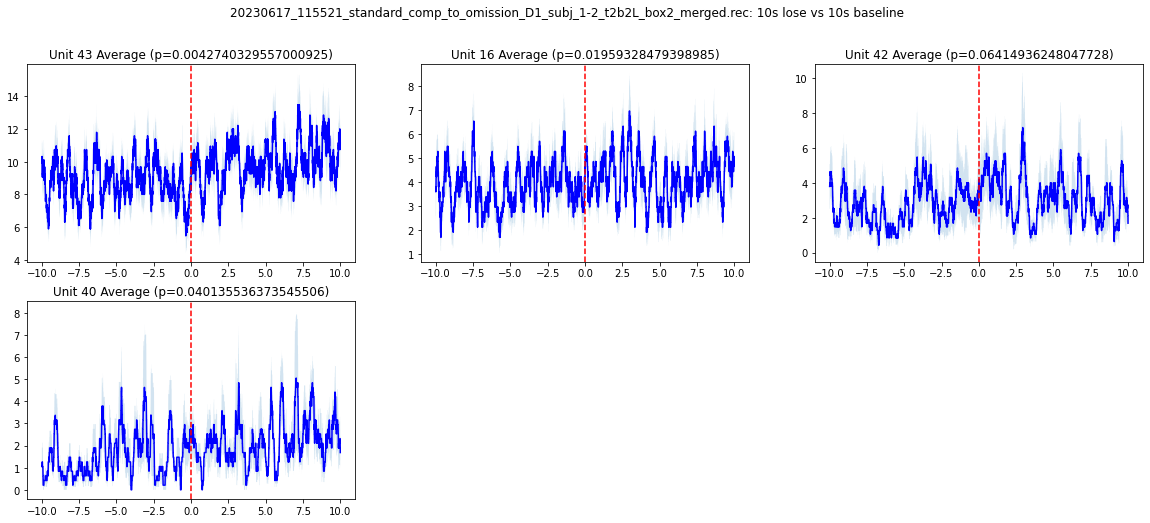

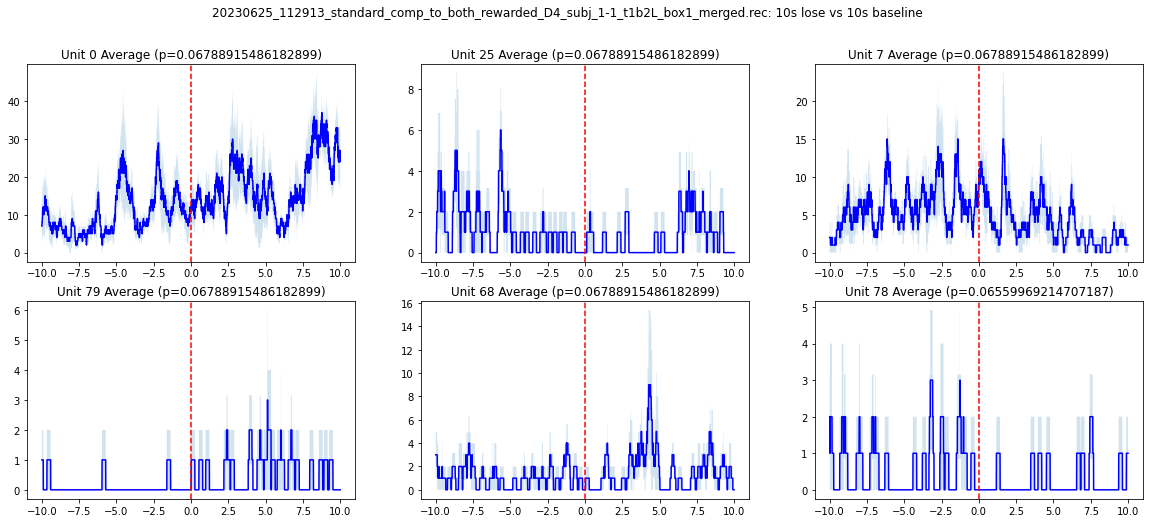

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

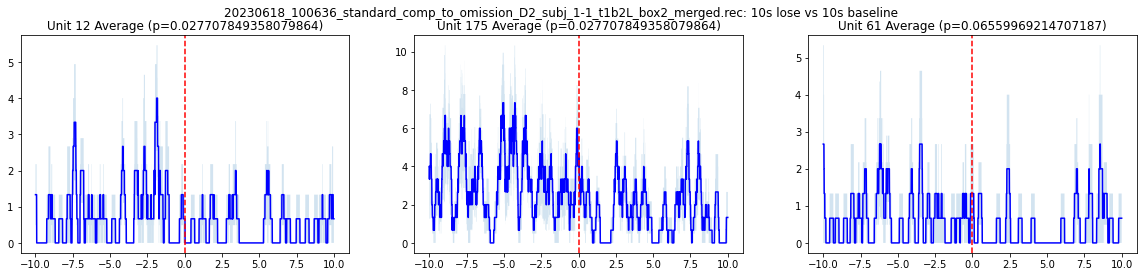

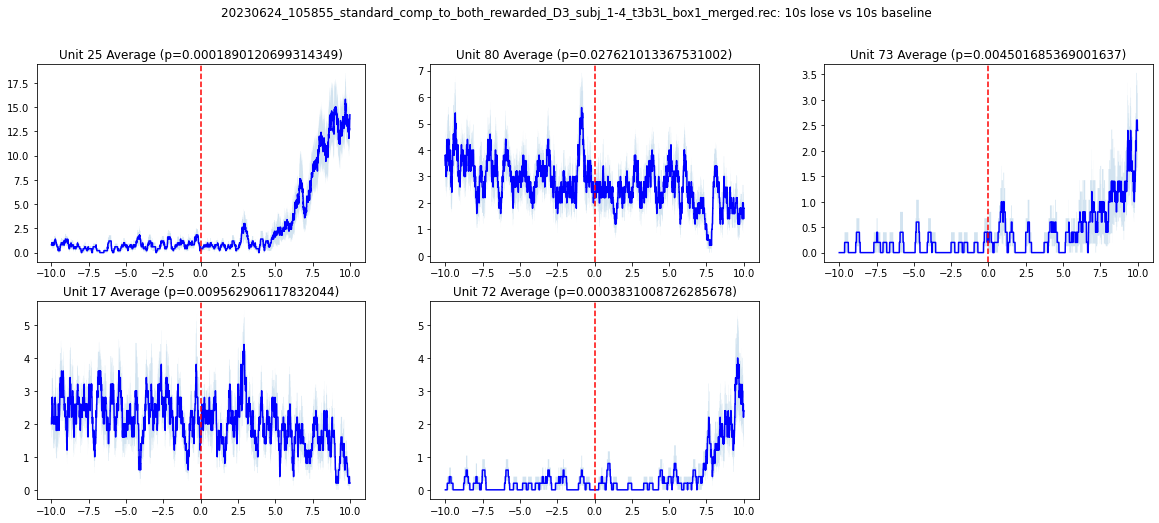

<Figure size 1440x0 with 0 Axes>

In [14]:
ephys_lose = spike_analysis.wilcox_baseline_v_event_collection('lose', 10, 10)

/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


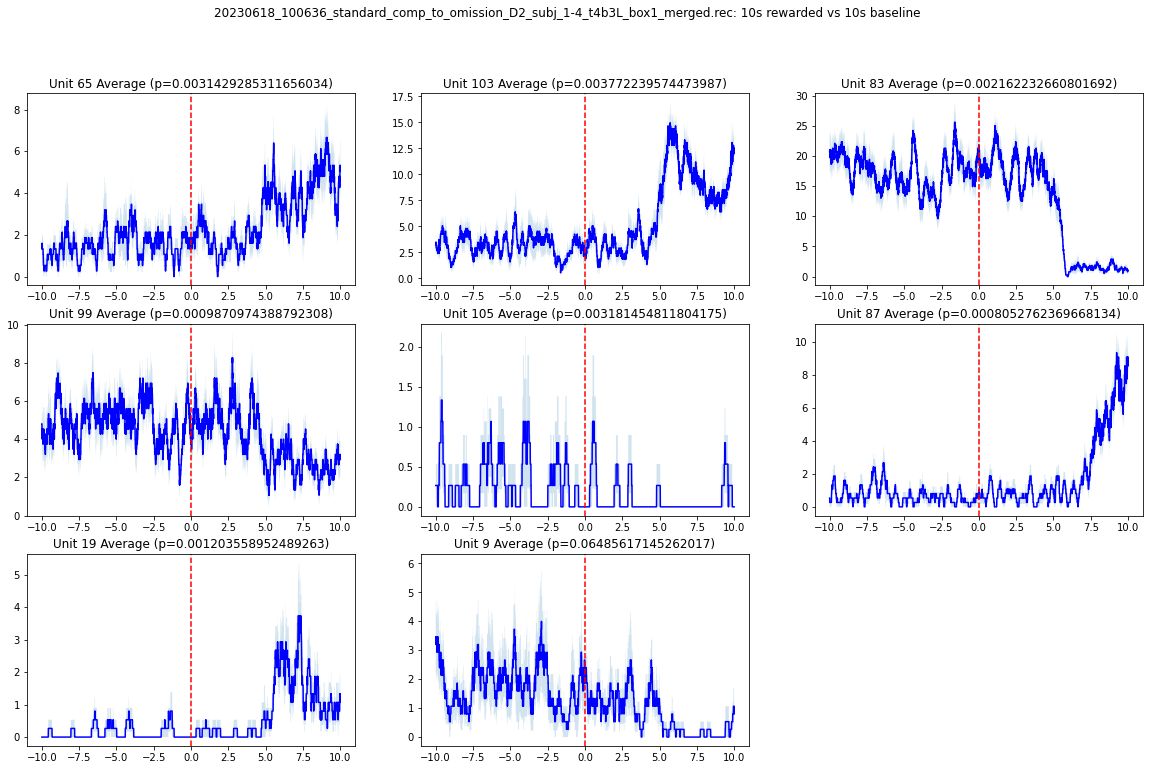

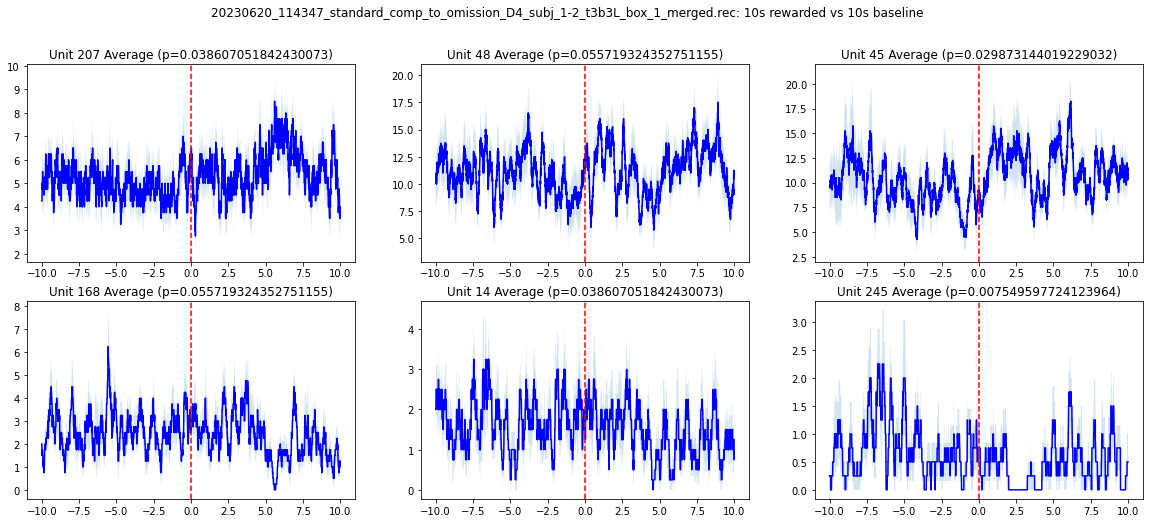

<Figure size 1440x0 with 0 Axes>

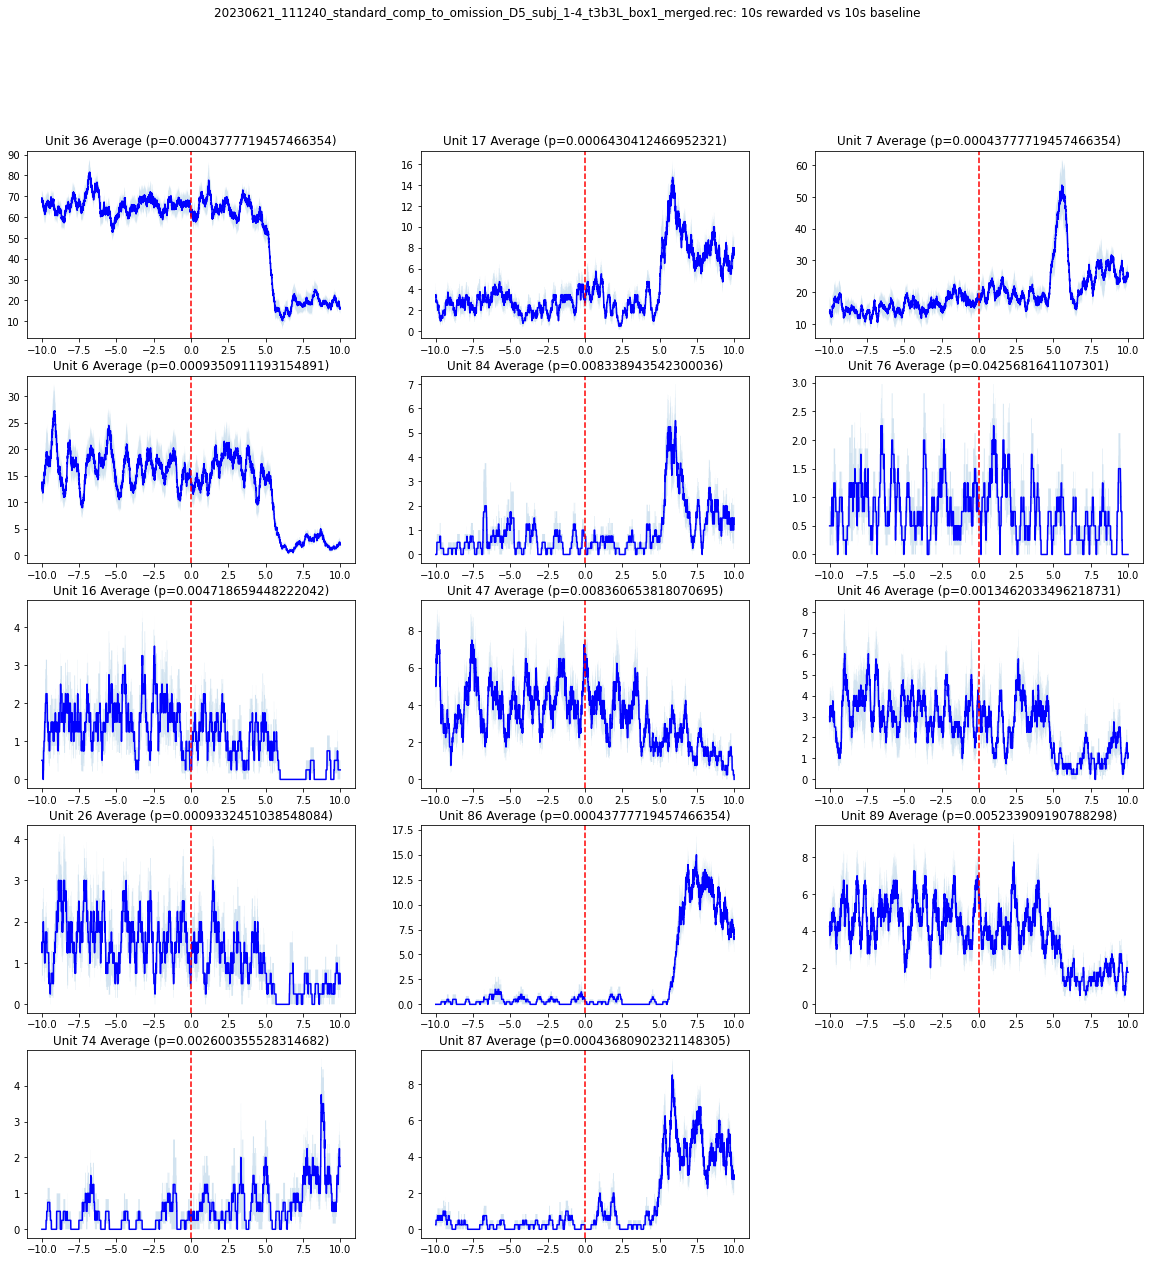

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

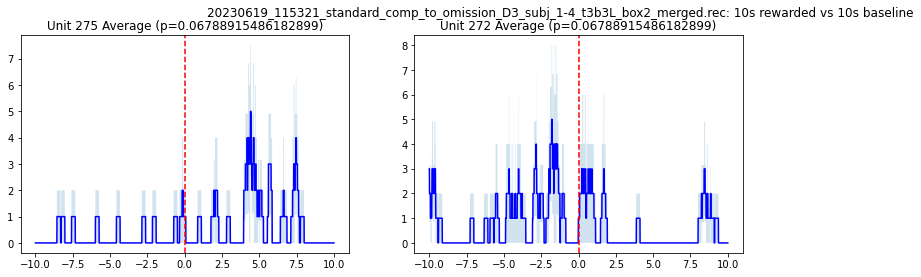

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

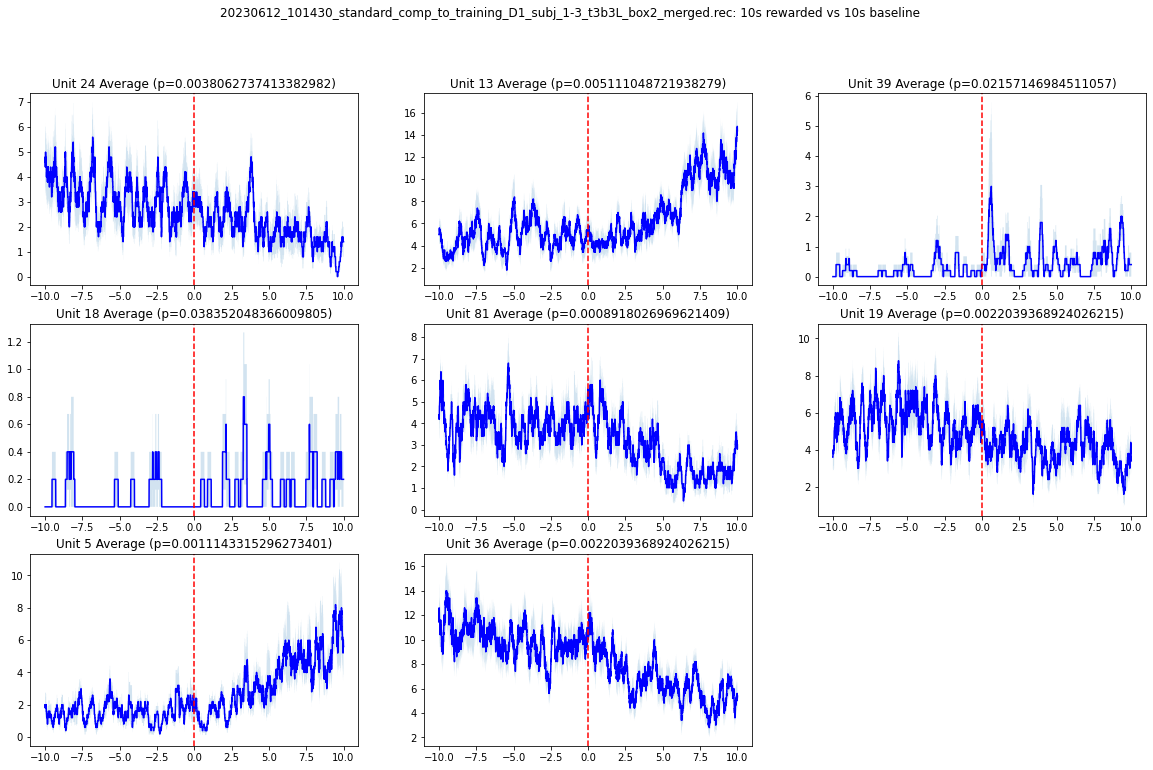

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

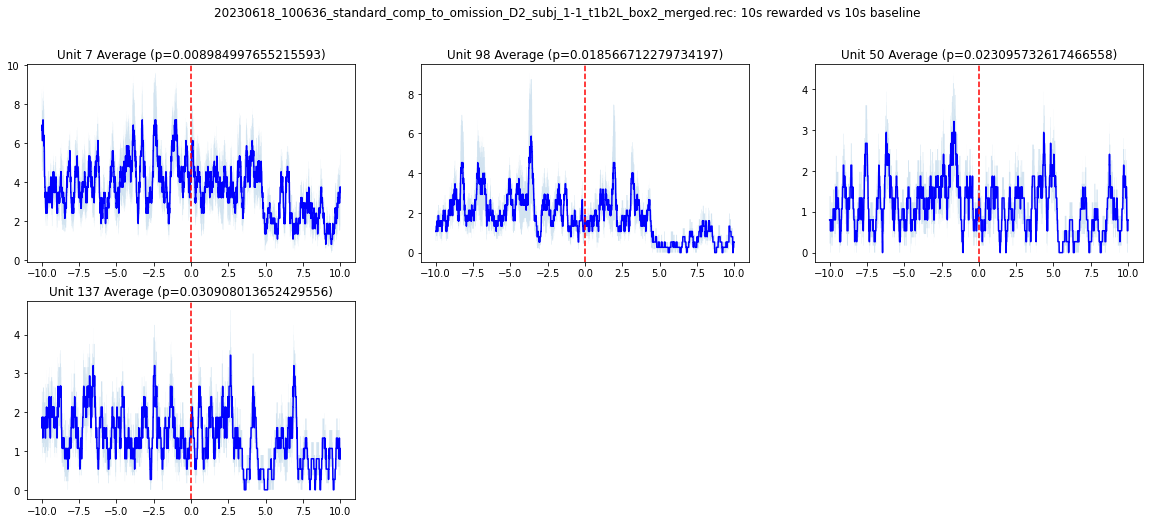

<Figure size 1440x0 with 0 Axes>

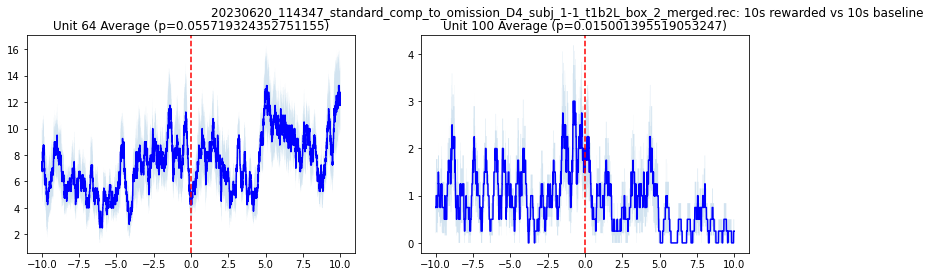

In [10]:
ephys_rewarded = spike_analysis.wilcox_baseline_v_event_collection('rewarded', 10, 10)

In [11]:
ephys_omission = spike_analysis.wilcox_baseline_v_event_collection('omission', 10, 10)

/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


ValueError: zero_method 'wilcox' and 'pratt' do not work if x - y is zero for all elements.

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

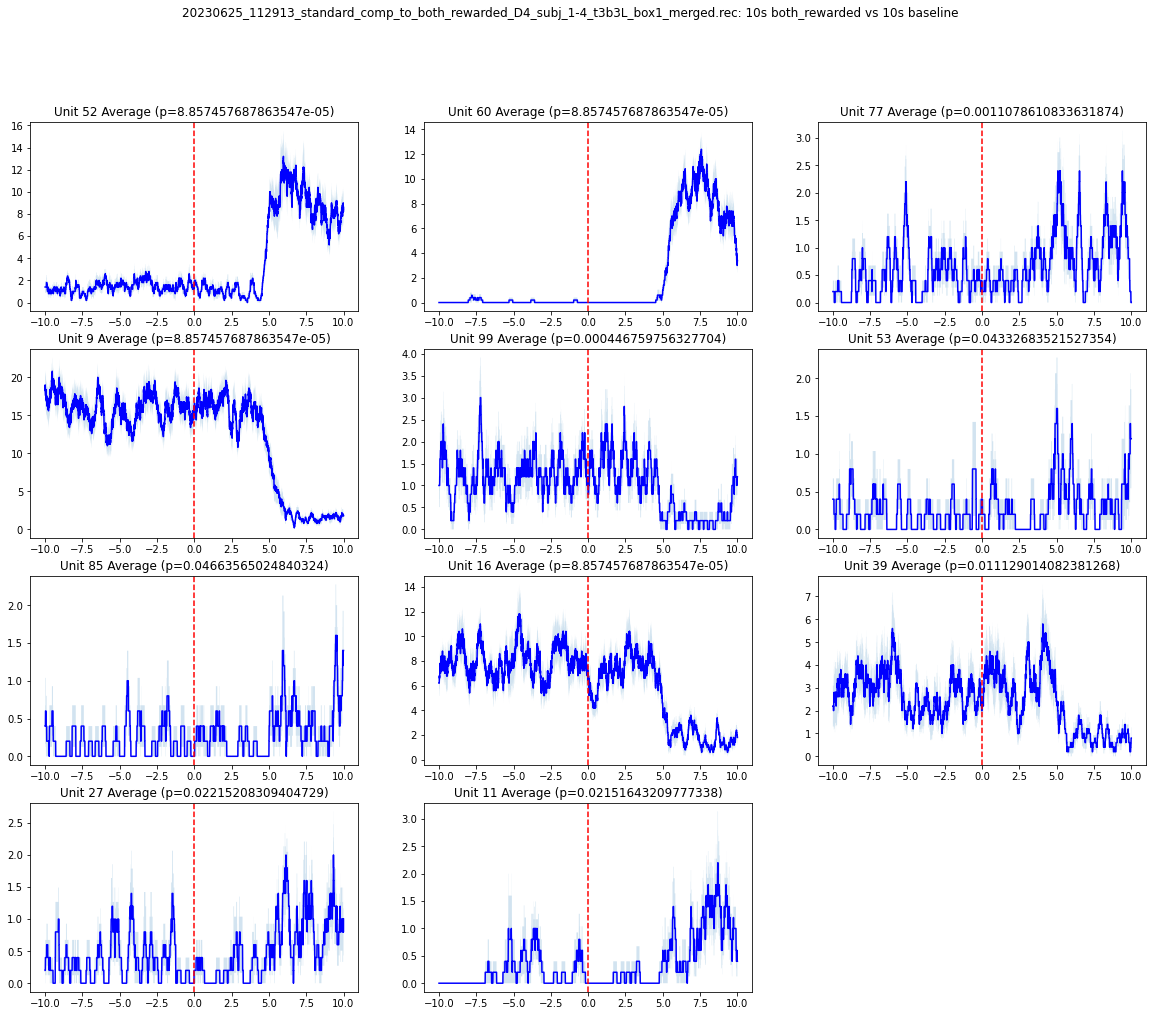

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

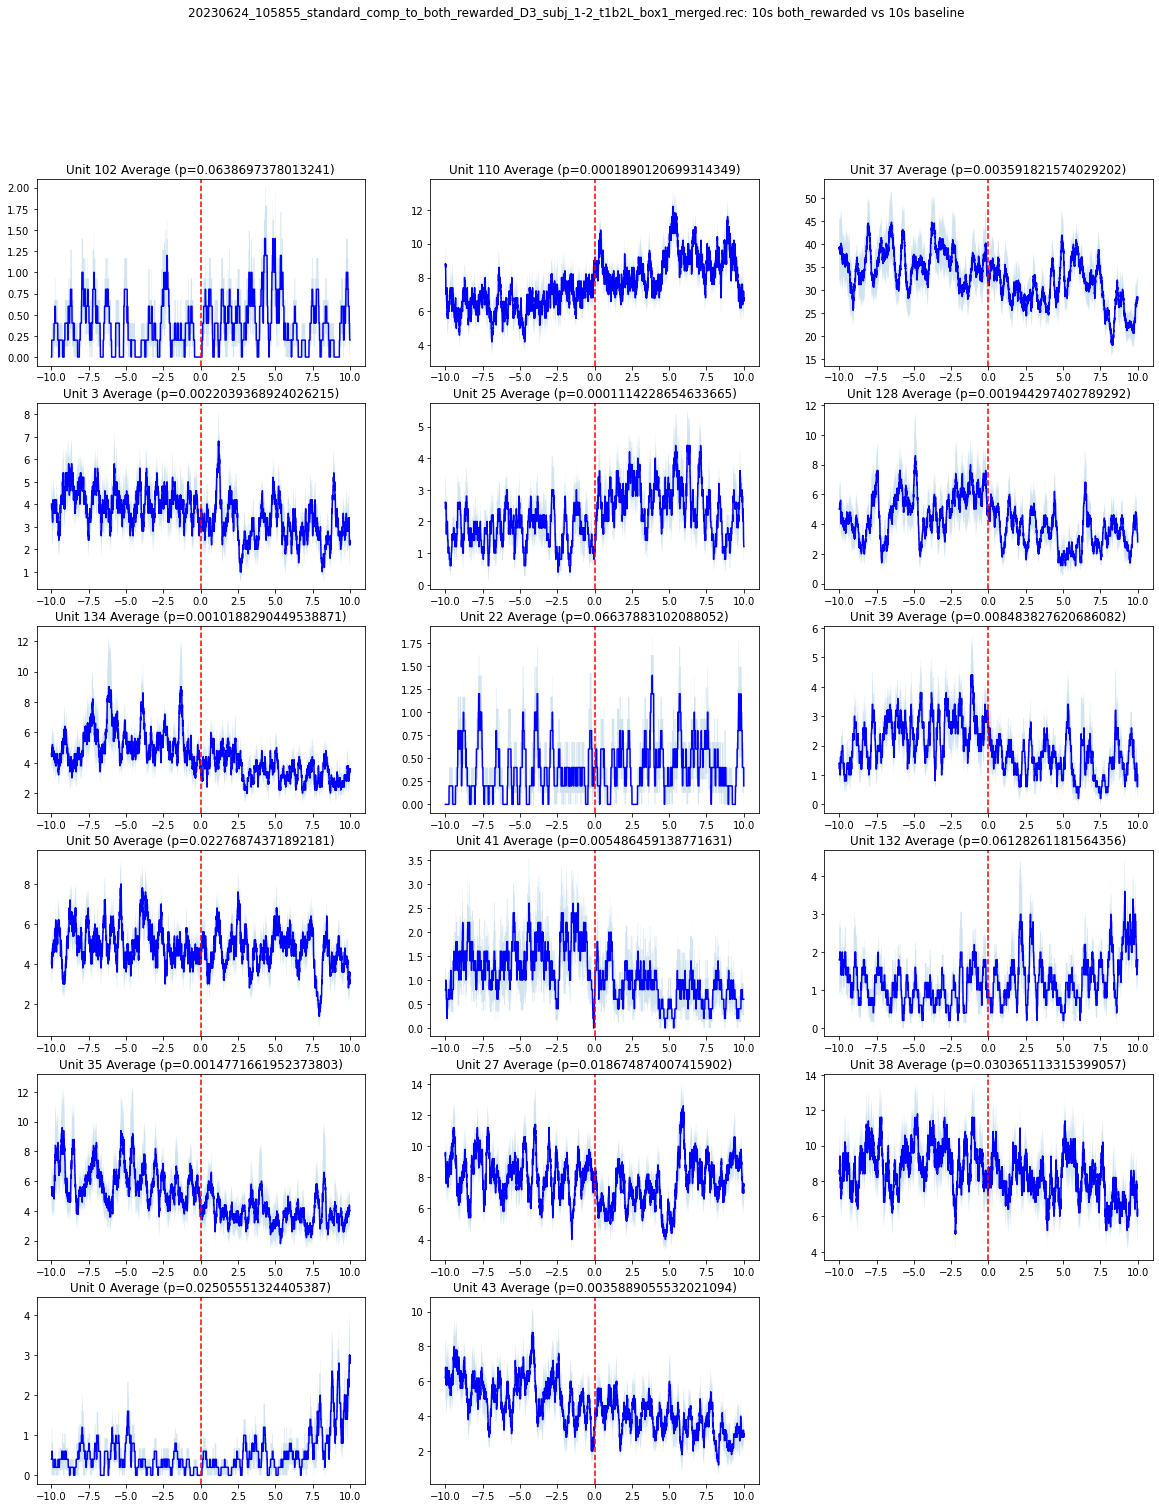

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

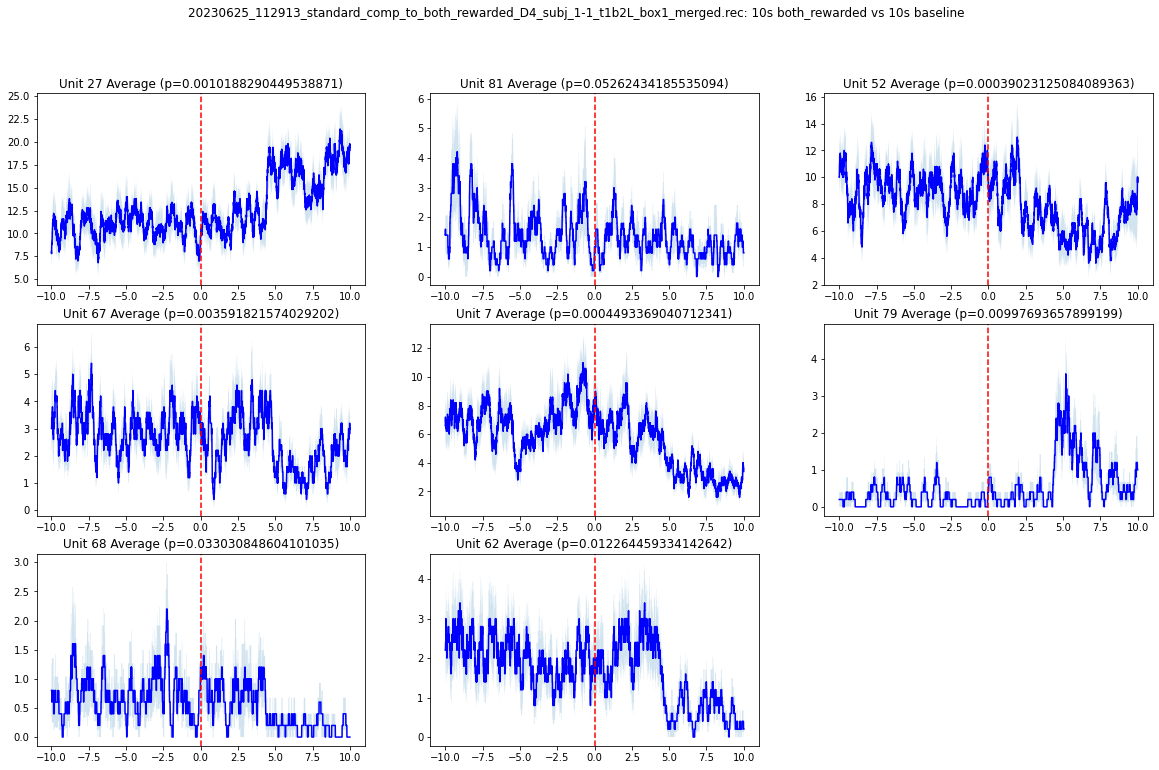

<Figure size 1440x0 with 0 Axes>

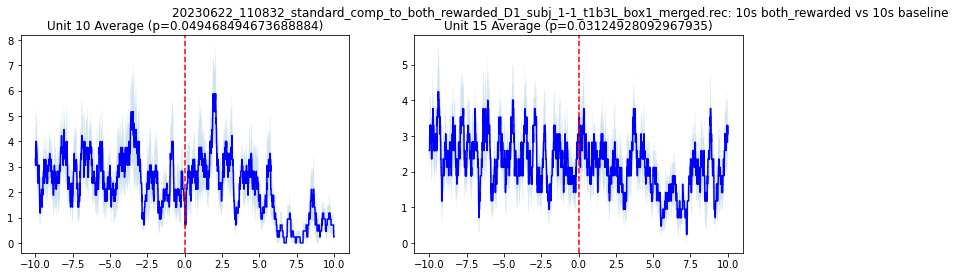

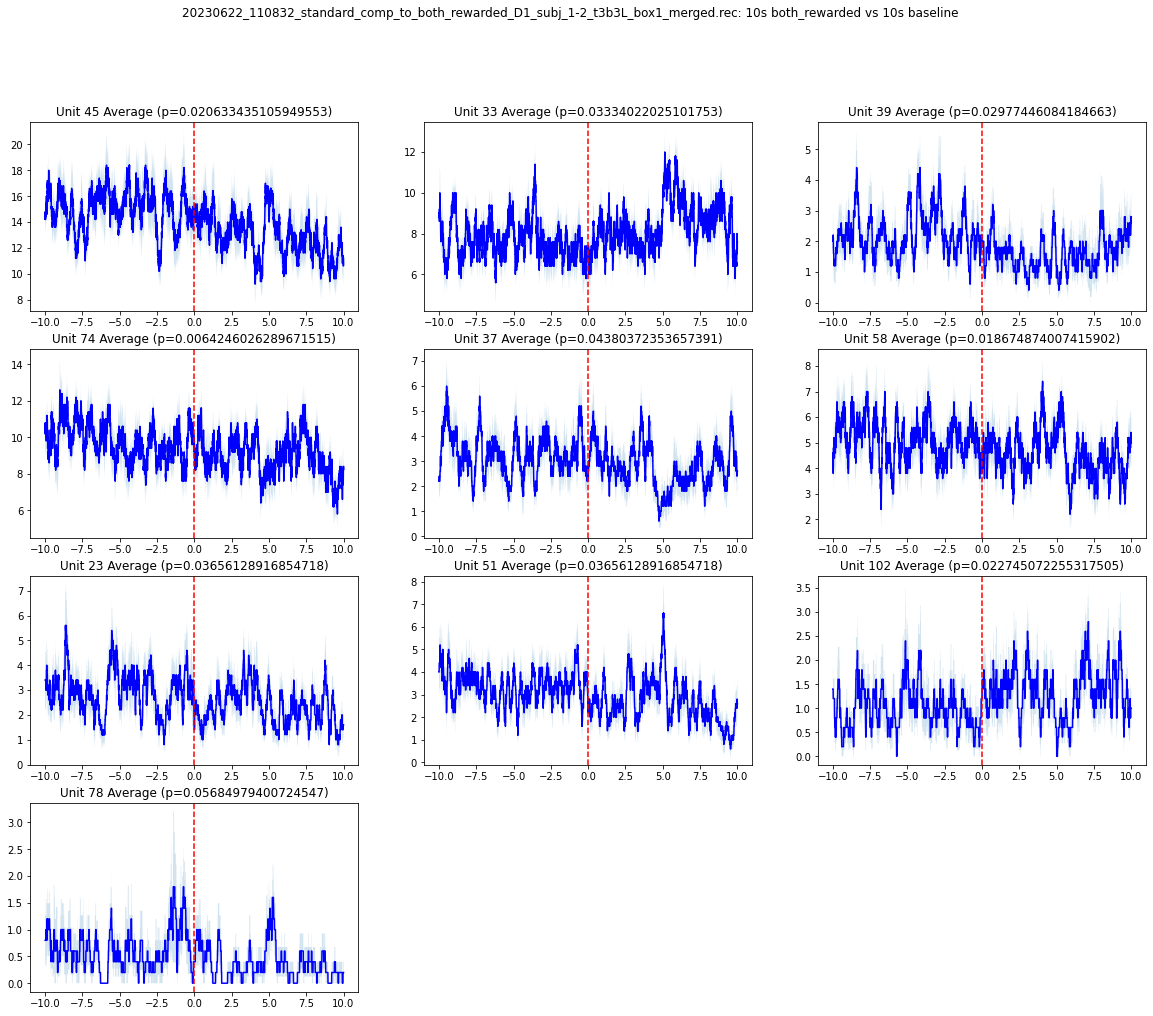

<Figure size 1440x0 with 0 Axes>

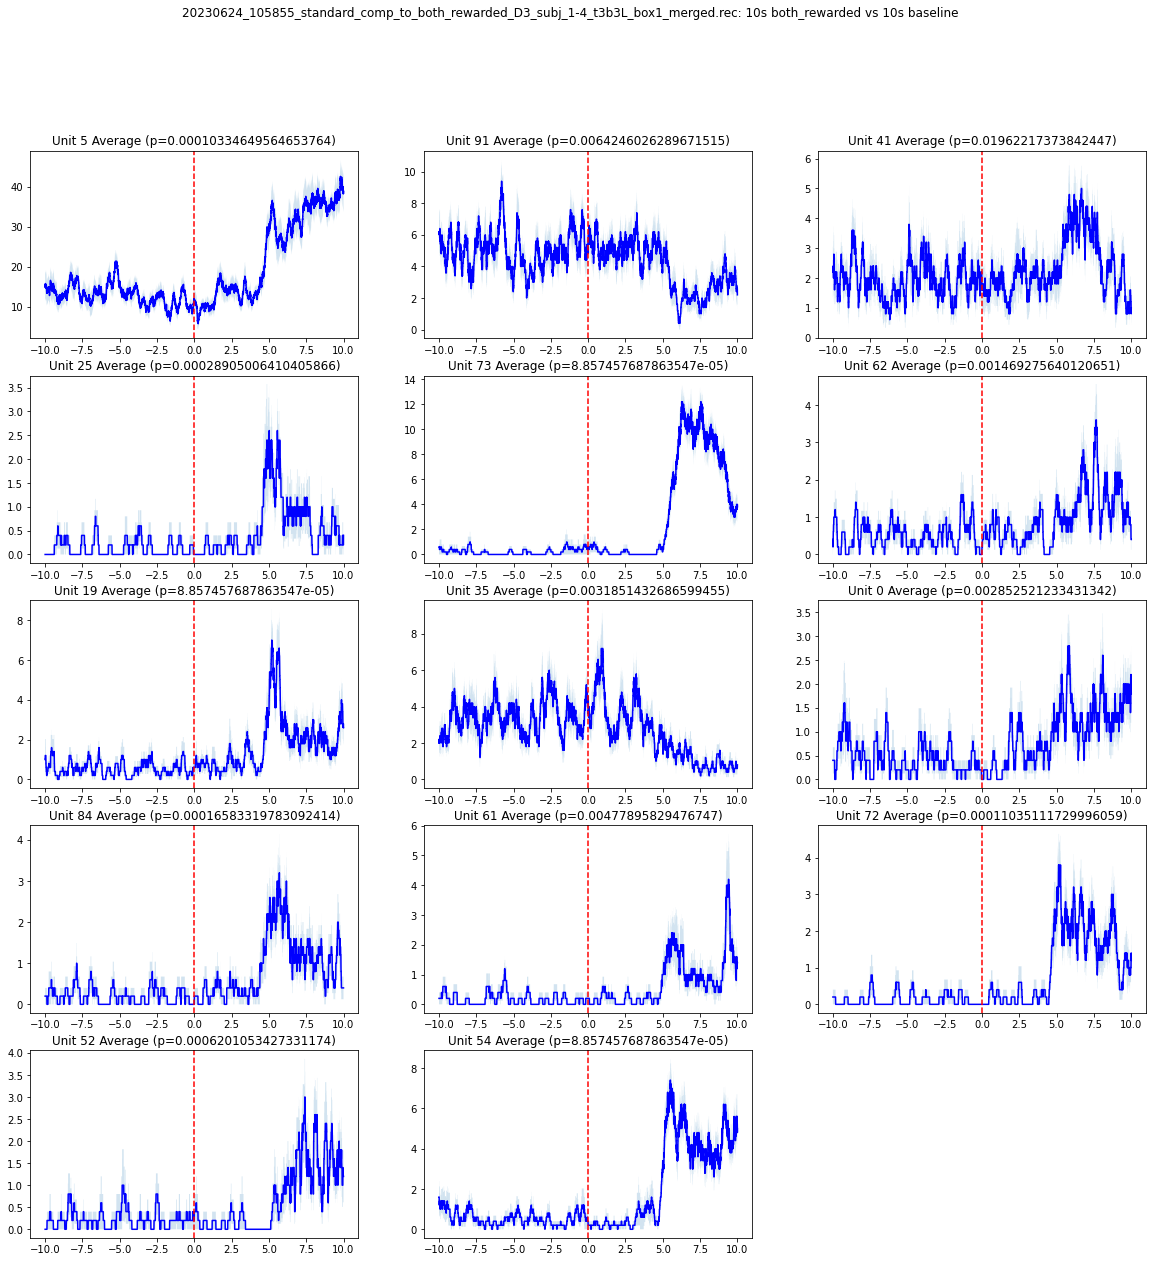

<Figure size 1440x0 with 0 Axes>

In [12]:
ephys_both_rewarded = spike_analysis.wilcox_baseline_v_event_collection('both_rewarded', 10, 10)

In [15]:
ephys_tie = spike_analysis.wilcox_baseline_v_event_collection('tie', 10, 10)

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

In [16]:
ephys_tie

original unit id  Wilcoxon Stat  p value event1 vs event2  \
0                  65            NaN      NaN  not significant   
1                 123            NaN      NaN  not significant   
2                 103            NaN      NaN  not significant   
3                  83            NaN      NaN  not significant   
4                 118            NaN      NaN  not significant   
..                ...            ...      ...              ...   
303               122            NaN      NaN  not significant   
304                22            NaN      NaN  not significant   
305               126            NaN      NaN  not significant   
306               100            NaN      NaN  not significant   
307                 2            NaN      NaN  not significant   

                                             Recording  \
0    20230618_100636_standard_comp_to_omission_D2_s...   
1    20230618_100636_standard_comp_to_omission_D2_s...   
2    20230618_100636_standard_comp_to_omission_D2_s...   
3    20230618_100636_standard_comp_to_omission_D2_s...   
4    20230618_100636_standard_comp_to_omission_D2_s...   
..                                                 ...   
303  20230620_114347_standard_comp_to_omission_D4_s...   
304  20230620_114347_standard_comp_to_omission_D4_s...   
305  20230620_114347_standard_comp_to_omission_D4_s...   
306  20230620_114347_standard_comp_to_omission_D4_s...   
307  20230620_114347_standard_comp_to_omission_D4_s...   

                        Subject                    Event  
0     1-4_t4b3L_box1_merged.rec  10s tie vs 10s baseline  
1     1-4_t4b3L_box1_merged.rec  10s tie vs 10s baseline  
2     1-4_t4b3L_box1_merged.rec  10s tie vs 10s baseline  
3     1-4_t4b3L_box1_merged.rec  10s tie vs 10s baseline  
4     1-4_t4b3L_box1_merged.rec  10s tie vs 10s baseline  
..                          ...                      ...  
303  1-1_t1b2L_box_2_merged.rec  10s tie vs 10s baseline  
304  1-1_t1b2L_box_2_merged.rec  10s tie vs 10s baseline  
305  1-1_t1b2L_box_2_merged.rec  10s tie vs 10s baseline  
306  1-1_t1b2L_box_2_merged.rec  10s tie vs 10s baseline  
307  1-1_t1b2L_box_2_merged.rec  10s tie vs 10s baseline  

[308 rows x 7 columns]

In [19]:
new_df.to_csv('timestamp_labels.csv', index=False)

In [22]:
spike_analysis.fishers_exact_wilcox('win', 'lose', 10, event3=None, 
                             baseline_window=10, offset=0,
                             exclude_offset=False, save=False)

/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too

(0.8713692946058091, 0.6088235871041234, [[35, 241], [35, 210]])

/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)
/apps/python/3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9205: RuntimeWarning: invalid value encountered in scalar divide
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


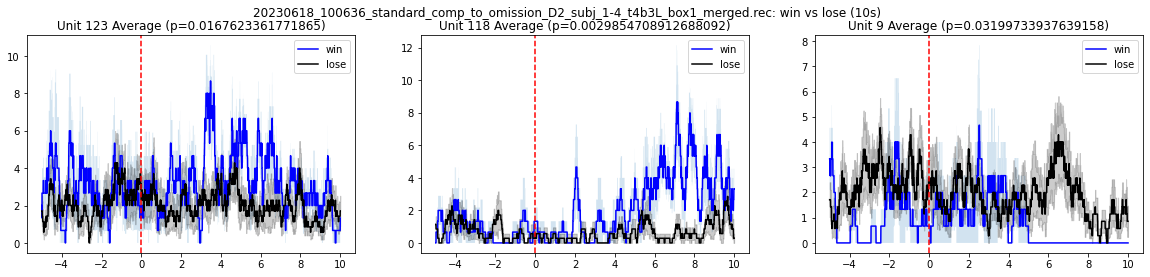

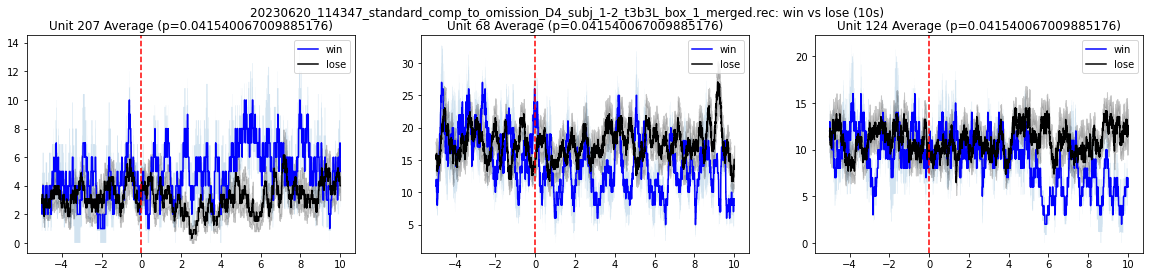

<Figure size 1440x0 with 0 Axes>

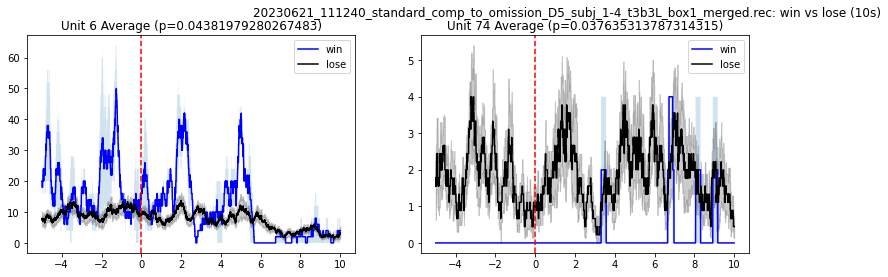

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

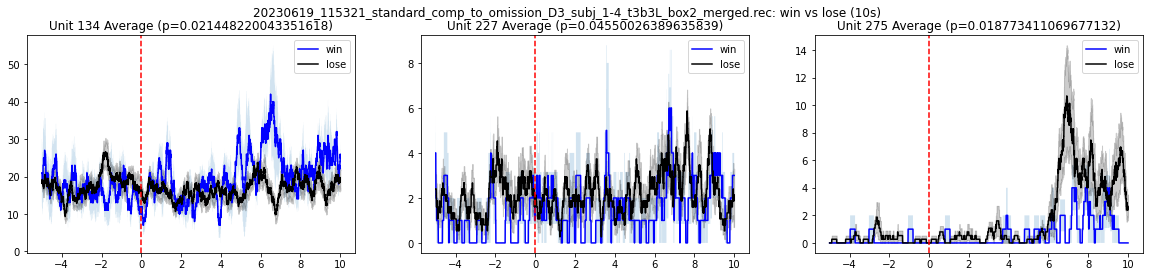

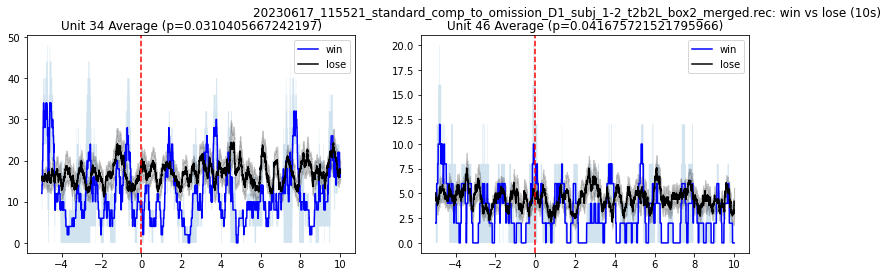

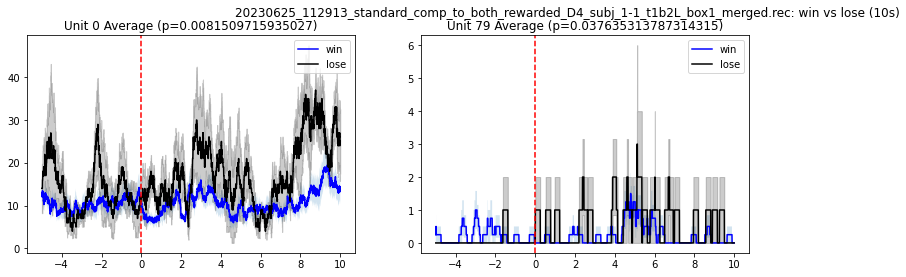

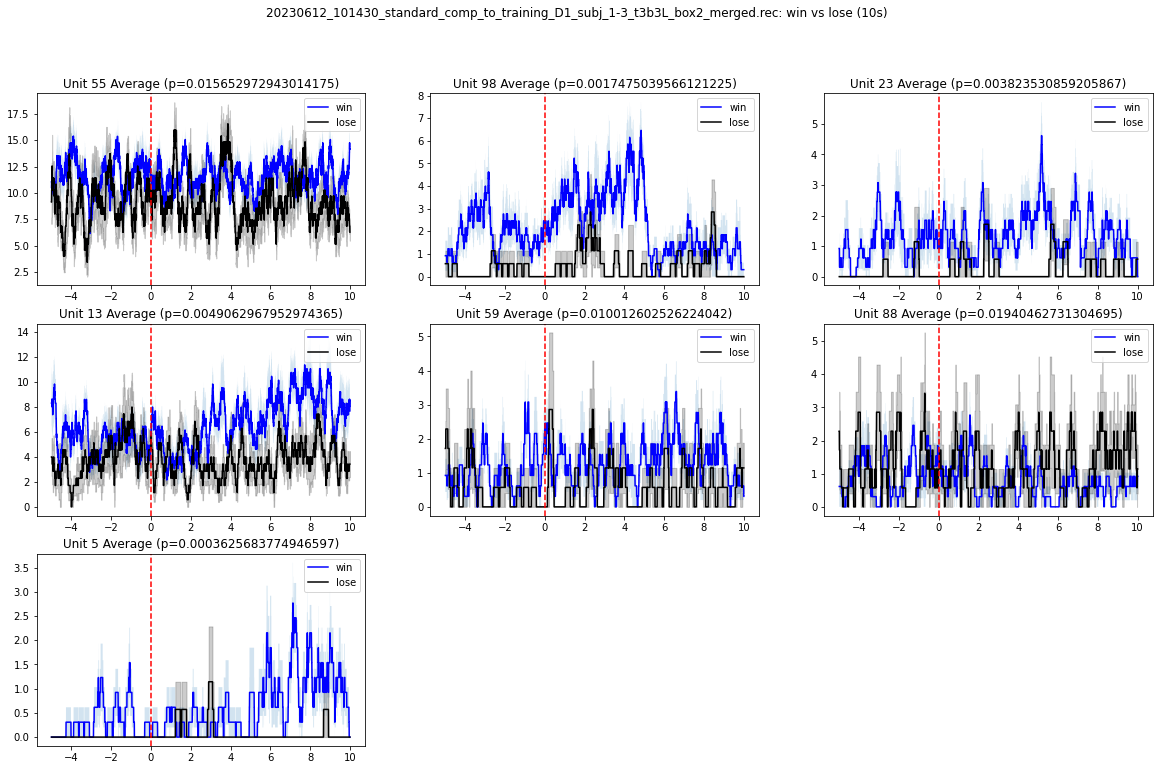

<Figure size 1440x0 with 0 Axes>

<Figure size 1440x0 with 0 Axes>

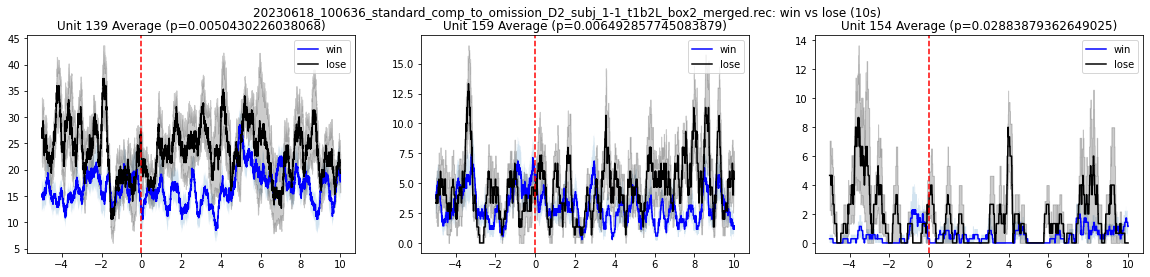

<Figure size 1440x0 with 0 Axes>

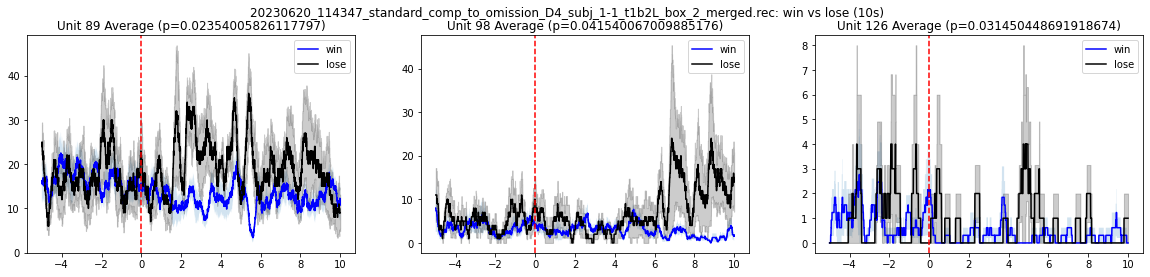

In [23]:
spike_analysis.wilcox_event_v_event_collection('win', 'lose', 10, 5, plot=True, save=False)

In [25]:
spike_analysis.zscore_global('win', 10, pre_window = 0, global_timebin = 1000, SD = 2, plot = True, save = False)

/apps/python/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/apps/python/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable

In [29]:
spike_analysis.zscore_baseline_event('win', 'lose', 10, pre_window = 0, plot = True, save = False)

/apps/python/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/apps/python/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/apps/python/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/apps/python/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


TypeError: 'numpy.float64' object is not iterable

In [32]:
spike_analysis.zscore_pre_event('win', 'lose', 10, offset = 0, plot = True, save = False)

TypeError: can only concatenate str (not "int") to str